# ION CHANNEL DETECTION // DENOISING 1D TIME SIGNAL

## KAGGLE INTRODUCTION

Many diseases, including cancer, are believed to have a contributing factor in common. Ion channels are pore-forming proteins present in animals and plants. They encode learning and memory, help fight infections, enable pain signals, and stimulate muscle contraction. If scientists could better study ion channels, which may be possible with the aid of machine learning, it could have a far-reaching impact.



When ion channels open, they pass electric currents. Existing methods of detecting these state changes are slow and laborious. Humans must supervise the analysis, which imparts considerable bias, in addition to being tedious. These difficulties limit the volume of ion channel current analysis that can be used in research. Scientists hope that technology could enable rapid automatic detection of ion channel current events in raw data.

The University of Liverpool’s Institute of Ageing and Chronic Disease is working to advance ion channel research. Their team of scientists have asked for your help. In this competition, you’ll use ion channel data to better model automatic identification methods. If successful, you’ll be able to detect individual ion channel events in noisy raw signals. The data is simulated and injected with real world noise to emulate what scientists observe in laboratory experiments.

Technology to analyze electrical data in cells has not changed significantly over the past 20 years. If we better understand ion channel activity, the research could impact many areas related to cell health and migration. From human diseases to how climate change affects plants, faster detection of ion channels could greatly accelerate solutions to major world problems.

## IMPORT LIBRARIES

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math as math
import tensorflow_addons as tfa
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, f1_score
from tensorflow.keras.callbacks import Callback
from pykalman import KalmanFilter
from scipy.ndimage.interpolation import shift
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier


## DATA

**train.csv**: contains three columns [time, signal, open_channels]. 10 data series are provided, the length of each serie is 500000, which comprise 50 seconds. The file provides the 10 series consecutively. This is first series goes from [0:499999], the second [500000:999999],... The maximum number of channels open is 10, hence, there are 11 possible outputs 0..10. Added to the signal, there is random noise and different forms of drift.

**test.csv**: contains two columns [time, signal]. It contains 4 data series similar to the ones found in training data.

Notice that not all the series have 10 channels, only 4 and 9. While noise appear in all the signals, drif only appears in series 1 and 6 to 9.

When it is observed a x-y plot, it is clear that there is not a direct relation between them. At any time, the state of the ion channels depends only on the previous state through a Markov stochastic model. Check more detail on the data generation in: [**Deep-Channel uses deep neural networks to detect
single-molecule events from patch-clamp data**](https://www.nature.com/articles/s42003-019-0729-3).

To improve results, it can be used a pre-cleaned data from [Chris Deotte](https://www.kaggle.com/cdeotte/data-without-drift)


In [2]:
## Path to data folder
PATH_DATA = "Data/"

In [3]:
## Downloading labels
df = pd.read_csv(PATH_DATA+"train_clean.csv")  # Pre-cleaned data
## df = pd.read_csv(PATH_DATA+"train.csv")

#del xf
y= pd.DataFrame()
y['open_channels']=df['open_channels']
xf= pd.DataFrame()
xf['signal0']=df['signal']

print("Shape of label matrix y is: (%d,%d)" %y.shape)
print("Shape of label matrix x is: (%d,%d)" %xf.shape)

Shape of label matrix y is: (5000000,1)
Shape of label matrix x is: (5000000,1)


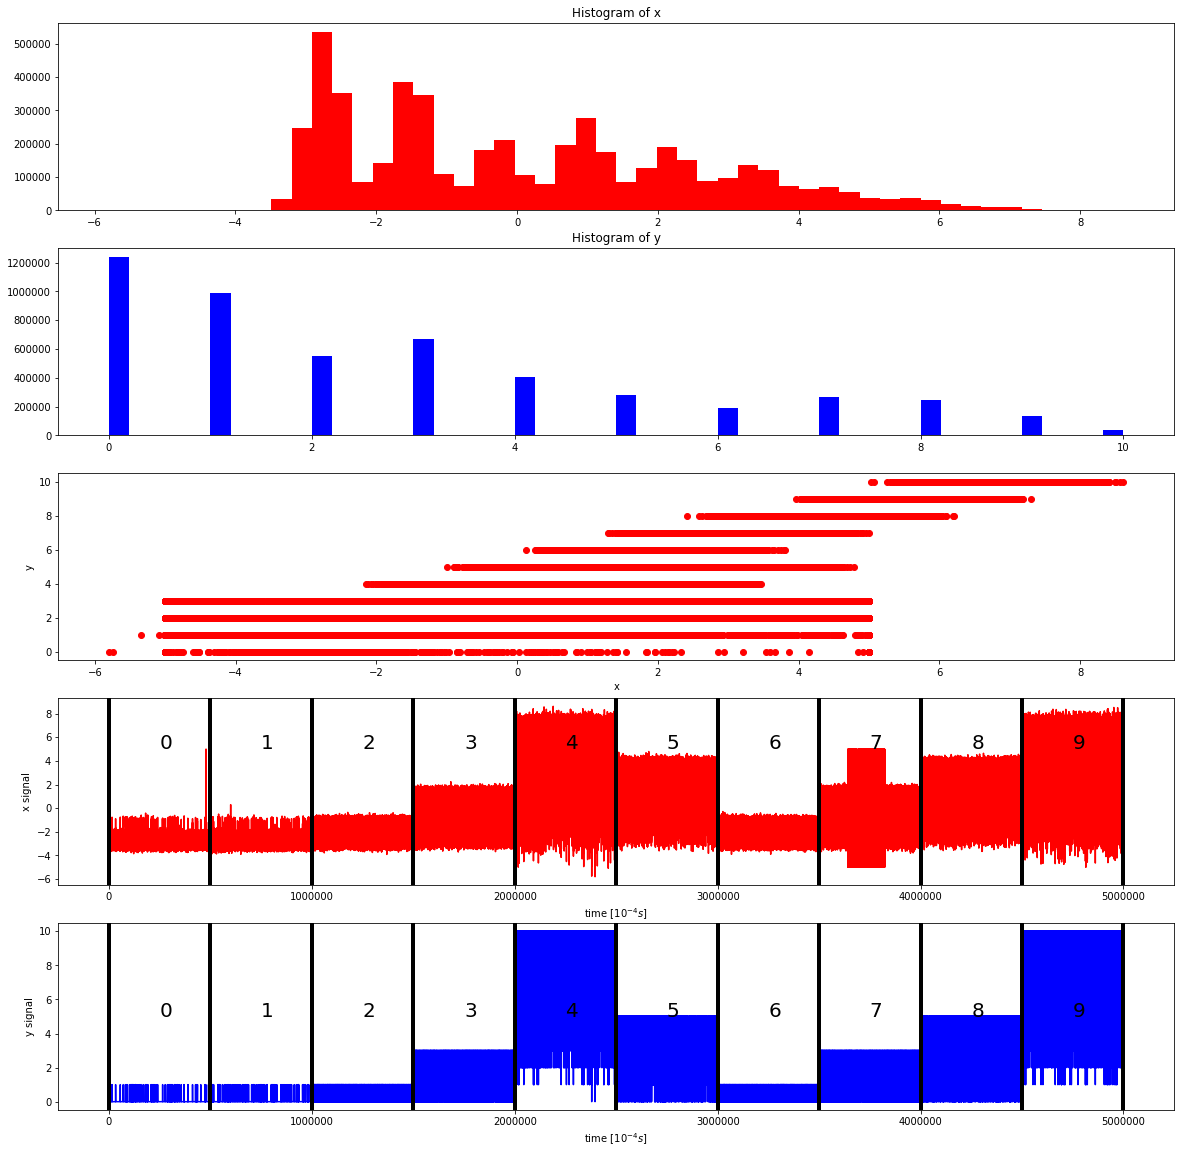

In [4]:
plt.figure(figsize=(20,20))
plt.subplot(511)
plt.hist(xf['signal0'], bins=50,color='red')
plt.title('Histogram of x')
plt.subplot(512)
plt.hist(y['open_channels'], bins=50,color='blue')
plt.title('Histogram of y')
plt.subplot(513)
plt.scatter(xf['signal0'],y['open_channels'],color='red')
plt.ylabel('y')
plt.xlabel('x')
plt.subplot(514)
plt.plot(np.arange(xf.shape[0]),xf,color='red')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('x signal')
plt.xlabel('time [$10^{-4} s$]')
plt.subplot(515)
plt.plot(np.arange(y['open_channels'].shape[0]),y['open_channels'],color='blue')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('y signal')
plt.xlabel('time [$10^{-4} s$]')
plt.show()

# Feature engineering

In [5]:
def create_batch(df,batch):
    ## Creates columns batch
    ## INPUTS
    #  df: pandas DataFrame
    #  batch: number of batches
    ## OUTPUT
    #  df updated    
    m=df.shape[0]
    mb=m//batch
    df['batch']=df.index//mb
    return df

def fillNAN(df,batch):
    ## Fill NaN with nearest value in the batch
    ## INPUTS
    #  df: pandas DataFrame
    #  batch: number of batches
    ## OUTPUT
    #  df updated
    df=df.groupby('batch').fillna(method='ffill')
    df=create_batch(df,BATCH)
    df=df.groupby('batch').fillna(method='bfill')
    df=create_batch(df,BATCH)
    return df

def add_shift(df,nshift,batch):
    ## Adds to 'signal0' nshifts in + and - direction
    ## INPUTS
    #  df: pandas DataFrame
    #  nshift: number of shifts
    #  batch: number of batches
    ## OUTPUT
    #  df updated
    dfb = df.groupby('batch')
    for i in range(1,nshift+1):
        df['signal'+str(i)]=dfb['signal0'].shift(periods=i)
        df['signal-'+str(i)]=dfb['signal0'].shift(periods=-i)
    df = fillNAN(df,batch)
    return df

def differences(df,nshift):
    ## Adds to difference between signals '(signal-ns)-(signal-ns+1)'..'(signal+ns-1)-(signal+ns)'
    ## INPUTS
    #  df: pandas DataFrame
    #  nshift: number of shifts
    ## OUTPUT
    #  df updated
    for i in range(-nshift,nshift):
        df['signalDif('+str(i+1)+')-('+str(i)+')']=df['signal'+str(i+1)]-df['signal'+str(i)]        
    return df

def windowmmm(df,windows,nshift,batch,plot=0):
    ## Apply windows for MAX, MIN and MEAN, MAX-MEAN, MIN-MEAN, MAX-MIN, (signal0-MIN)/(MAX-MIN)
    ## for last window, it also includes STD and (signalk-MEAN) with k=[-nshift..nshift]
    ## INPUTS
    #  df: pandas DataFrame
    #  windows: list with window sizes
    #  nshift: number of shifts for last window
    #  batch: number of batches
    #  plot: verbose if ==1
    ## OUTPUT
    #  df updated
    dfb=df.groupby('batch')
    NW=len(windows)
    for i in range(NW):
        w=windows[i]
        if plot==1:
            print('Window: %d' %w)
        df['MAX_W'+str(w)]=dfb['signal0'].transform(lambda x: x.rolling(w,center=True).max().fillna(method='ffill').fillna(method='bfill'))
        df['MIN_W'+str(w)]=dfb['signal0'].transform(lambda x: x.rolling(w,center=True).min().fillna(method='ffill').fillna(method='bfill'))
        df['MEAN_W'+str(w)]=dfb['signal0'].transform(lambda x: x.rolling(w,center=True).mean().fillna(method='ffill').fillna(method='bfill'))
        df['MAX-MEAN_W'+str(w)]=df['MAX_W'+str(w)]-df['MEAN_W'+str(w)]
        df['MIN-MEAN_W'+str(w)]=df['MIN_W'+str(w)]-df['MEAN_W'+str(w)]
        df['MAX-MIN_W'+str(w)]=df['MAX_W'+str(w)]-df['MIN_W'+str(w)]
        if i==(NW-1):
            df['STD_W'+str(w)]=dfb['signal0'].transform(lambda x: x.rolling(w,center=True).std())
    df = fillNAN(df,batch)
    for i in range(NW):
        df['(signal-MIN)_DIV(MAX-MIN)_W'+str(w)]=(df['signal0']-df['MIN_W'+str(w)])/(df['MAX_W'+str(w)]-df['MIN_W'+str(w)])
        if i==(NW-1):
            for k in range(-nshift,nshift+1):
                df['signal'+str(k)+'-MEAN_W'+str(w)]=df['signal'+str(k)]-df['MEAN_W'+str(w)]
    return df

def FFTFILTERS(df,harmonicHP,harmonicLP,batch,removebias,Kalman=0,plot=0):
    ## Apply FFT filters
    ## INPUTS
    #  df: pandas DataFrame
    #  harmonicHP: number of removed harmonics from low frequency (high pass)
    #  harmonicLP: number of removed harmonics from high frequency (low pass)
    #  batch: number of batches
    #  removebias==1 then bias removed in HP filter
    #  Kalman==1 then Kalman filter applied in HP filter
    #  plot: verbose if ==1
    ## OUTPUT
    #  df updated   
    x=df['signal0'].to_numpy()
    for h in harmonicHP:
        if plot==1:
            print('HP'+str(h))
        df['HP'+str(h)+'signal0']=HighPassfilter(x,h,batch,removebias, Kalman)
    for h in harmonicLP:
        if plot==1:
            print('LP'+str(h))
        df['LP'+str(h)+'signal0']=LowPassfilter(x,h,batch)
    return df

def HighPassfilter(x,harmonic,batch,removebias=1, Kalman=0):
    ## INPUTS:
    # x: numpy array to remove low harmonics
    # harmonic: number of harmonics to remove
    # batch: x is batched before fft, before the output is flattened.
    # removebias: remove constant element from fft
    # Kalman: Apply Kalman filter if Kalman==1
    ## OUTPUTS:
    # x: numpy array flattened after high pass filter
    x=x.reshape(batch,-1)
    xf=np.fft.fft(x)
    if removebias==1:
        xf[:,0]=0
    xf[:,1:harmonic+1]=0
    xf[:,-harmonic:]=0    
    x=np.real(np.fft.ifft(xf))
    ## Kalman Filter 
    if Kalman==1:
        for i in range(batch):
            kf=KalmanFilter(transition_matrices=1,
                            observation_matrices=1,
                            transition_covariance=0.1,
                            observation_covariance=0.0015,
                            transition_offsets=0,
                            observation_offsets=0,
                            initial_state_mean=x[i,0],
                            initial_state_covariance=1)
            X_smooth=kf.smooth(x[i,:])
            X_smooth=X_smooth[0].reshape(1,-1)
            x[i,:]=X_smooth
    return x.reshape(-1,1)

def LowPassfilter(x,harmonic,batch):
    ## INPUTS:
    # x: numpy array to remove low harmonics
    # harmonic: number of harmonics to remove
    # batch: x is batched before fft, before the output is flattened.
    # removebias: remove constant element from fft
    # Kalman: Apply Kalman filter if Kalman==1
    ## OUTPUTS:
    # x: numpy array flattened after high pass filter
    x=x.reshape(batch,-1)
    xf=np.fft.fft(x)
    m=xf.shape[1]
    xf[:,m//2-harmonic//2:m//2+harmonic//2]=0
    x=np.real(np.fft.ifft(xf))
    return x.reshape(-1,1)

def quantiles(df,windows,nshift,batch,plot=0):
    ## Apply windows for Q25, Q50, Q75, Q75-Q25, (signal0-Q25)/(Q75-Q25)
    ## for last window, it also includes (signalk-Q25), (signalk-Q50) and (signalk-Q75) with k=[-nshift..nshift]
    ## INPUTS
    #  df: panda DataFrame
    #  windows: list with window sizes
    #  nshift: number of shifts for last window
    #  batch: number of batches
    #  plot: verbose if ==1
    ## OUTPUT
    #  df updated    
    dfb=df.groupby('batch')
    NW=len(windows)
    for i in range(NW):
        w=windows[i]
        if plot==1:
            print('Quantile Window: %d' %w)
        df['quantile25_W'+str(w)]=dfb['signal0'].transform(lambda x: x.rolling(w,center=True).quantile(0.25).fillna(method='ffill').fillna(method='bfill'))
        df['quantile50_W'+str(w)]=dfb['signal0'].transform(lambda x: x.rolling(w,center=True).quantile(0.50).fillna(method='ffill').fillna(method='bfill'))
        df['quantile75_W'+str(w)]=dfb['signal0'].transform(lambda x: x.rolling(w,center=True).quantile(0.75).fillna(method='ffill').fillna(method='bfill'))
        df['quantileINTER75-25_W'+str(w)]=df['quantile75_W'+str(w)]-df['quantile25_W'+str(w)]
        df['signal0-Q25_DIVquantileINTER75-25_W'+str(w)]=(df['signal0']-df['quantile25_W'+str(w)])/df['quantileINTER75-25_W'+str(w)]
        if i==(NW-1):
            for k in range(-nshift,nshift+1):
                df['signal'+str(k)+'-quantile25_W'+str(w)]=df['signal'+str(k)]-df['quantile25_W'+str(w)]
                df['signal'+str(k)+'-quantile50_W'+str(w)]=df['signal'+str(k)]-df['quantile50_W'+str(w)]
                df['signal'+str(k)+'-quantile75_W'+str(w)]=df['signal'+str(k)]-df['quantile75_W'+str(w)]
    return df

def FEATURE_ENGINEERING(df,batch,nshift,ndshift,window,harmonicHP,harmonicLP,plot=0):
    ## Apply all feature engineering
    ## INPUTS
    #  df: pandas DataFrame
    #  batch: number of batches
    #  nshift: number of shifts
    #  ndshift: number of shifts for differences
    #  windows: list with window sizes
    #  harmonicHP: number of removed harmonics from low frequency (high pass)
    #  harmonicLP: number of removed harmonics from high frequency (low pass)
    #  plot: verbose if ==1
    ## OUTPUT
    #  df updated without column 'batch'
    df=create_batch(df,batch)
    if plot==1:
        print('Creating shifts...')
    df=add_shift(df,nshift,batch)
    if plot==1:
        print('Creating differences...')
    df=differences(df,ndshift)
    df=windowmmm(df,window,nshift,batch,plot)
    df=quantiles(df,window,nshift,batch,plot)
    if plot==1:
        print('Creating FFT Filters...')
    df=FFTFILTERS(df,harmonicHP,harmonicLP,batch,removebias=1,Kalman=0,plot=plot)
    if plot==1:
        print('Feature engineering finished')
    df=df.drop(columns=['batch'])
    return df


NSHIFT=5
NDSHIFT=3
BATCH=10
WINDOWS=[5,10,50,200,500,1000,4000]
HARMONICHP=[100,1000,2000,4000,8000,16000,32000]
HARMONICLP=[100,1000,2000,4000,8000,16000,32000]


xf=FEATURE_ENGINEERING(xf,BATCH,NSHIFT,NDSHIFT,WINDOWS,HARMONICHP,HARMONICLP,plot=1)
features=list(xf.columns)

CrossValidationProp=0.1
NCHANNELX=xf.shape[1]
x_train, x_CV, y_train, y_CV = train_test_split(xf,y, test_size=CrossValidationProp, random_state=1)

Creating shifts...
Creating differences...
Window: 5
Window: 10
Window: 50
Window: 200
Window: 500
Window: 1000
Window: 4000
Quantile Window: 5
Quantile Window: 10
Quantile Window: 50
Quantile Window: 200
Quantile Window: 500
Quantile Window: 1000
Quantile Window: 4000
Creating FFT Filters...
HP100
HP1000
HP2000
HP4000
HP8000
HP16000
HP32000
LP100
LP1000
LP2000
LP4000
LP8000
LP16000
LP32000
Feature engineering finished


## CATBOOST model

In [6]:
## Training and validation data
train_dataset = Pool(data=x_train,
                     label=y_train)
eval_dataset = Pool(data=x_CV,
                    label=y_CV)


# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.01,
                           random_seed=2,
                           depth=8,
                           #max_leaves=63,
                           loss_function='MultiClass',
                           eval_metric='MultiClass',
                           custom_metric=['F1'],
                           metric_period=10,
                           early_stopping_rounds=10,
                           use_best_model=True,
                           task_type="GPU",
                           devices='0:1')


f1=model.get_evals_result()
# Fit model
model.fit(train_dataset,
          eval_set=eval_dataset,
          verbose=True)

#model.save_model("modelCATBOOST_V20200502")

#model = CatBoostClassifier()

#model.load_model("modelCATBOOST_V20200502")


0:	learn: 2.3101029	test: 2.3101937	best: 2.3101937 (0)	total: 530ms	remaining: 1h 28m 17s
10:	learn: 1.7413353	test: 1.7418531	best: 1.7418531 (10)	total: 4.99s	remaining: 1h 15m 28s
20:	learn: 1.4179707	test: 1.4187484	best: 1.4187484 (20)	total: 9.49s	remaining: 1h 15m 7s
30:	learn: 1.1972368	test: 1.1981851	best: 1.1981851 (30)	total: 13.9s	remaining: 1h 14m 42s
40:	learn: 1.0335058	test: 1.0345790	best: 1.0345790 (40)	total: 18.4s	remaining: 1h 14m 27s
50:	learn: 0.9052348	test: 0.9064181	best: 0.9064181 (50)	total: 22.8s	remaining: 1h 14m 14s
60:	learn: 0.8017999	test: 0.8030799	best: 0.8030799 (60)	total: 27.3s	remaining: 1h 14m 2s
70:	learn: 0.7168399	test: 0.7181954	best: 0.7181954 (70)	total: 31.7s	remaining: 1h 13m 56s
80:	learn: 0.6452073	test: 0.6466376	best: 0.6466376 (80)	total: 36.2s	remaining: 1h 13m 49s
90:	learn: 0.5843951	test: 0.5858925	best: 0.5858925 (90)	total: 40.7s	remaining: 1h 13m 47s
100:	learn: 0.5319257	test: 0.5334678	best: 0.5334678 (100)	total: 45.3s	r

In [7]:
model.save_model("modelCATBOOST_V20200502_V2")

#model = CatBoostClassifier()

#model.load_model("modelCATBOOST_V20200502_V2")

# Simulation plot

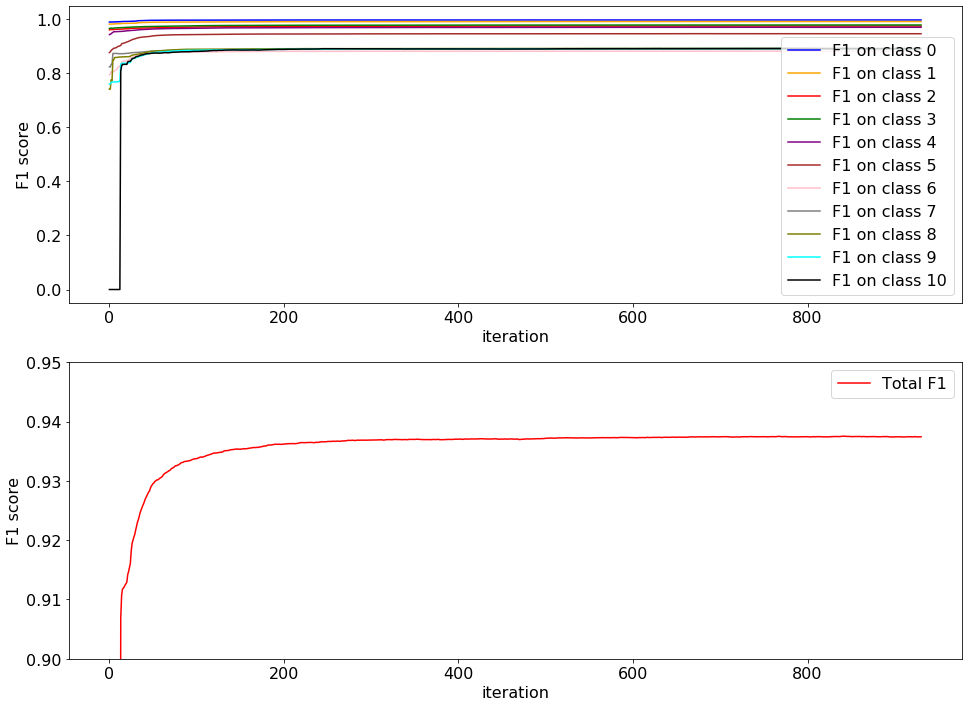

In [8]:
f1 = pd.read_csv('catboost_info/test_error.tsv',sep='\t')
NCLASSES=11
f1['TotalF1']=f1['iter']*0
for i in range(NCLASSES):
    f1['TotalF1']=f1['TotalF1']+f1['F1:class='+str(i)]/NCLASSES

colors={}
colors[0]="blue"
colors[1]="orange"
colors[2]="red"
colors[3]="green"
colors[4]="purple"
colors[5]="brown"
colors[6]="pink"
colors[7]="gray"
colors[8]="olive"
colors[9]="cyan"
colors[10]="black"
plt.figure(figsize=(16,12))
plt.subplot(211)
for i in range(NCLASSES):
    plt.plot(np.arange(f1['TotalF1'].shape[0]),f1['F1:class='+str(i)],color=colors[i],label='F1 on class '+str(i))
plt.xlabel("iteration",fontsize=16)
plt.ylabel("F1 score",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)

plt.subplot(212)
plt.plot(np.arange(f1['TotalF1'].shape[0]),f1['TotalF1'],color='red',label='Total F1')
plt.xlabel("iteration",fontsize=16)
plt.ylabel("F1 score",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.ylim(0.90,0.95)
plt.show()

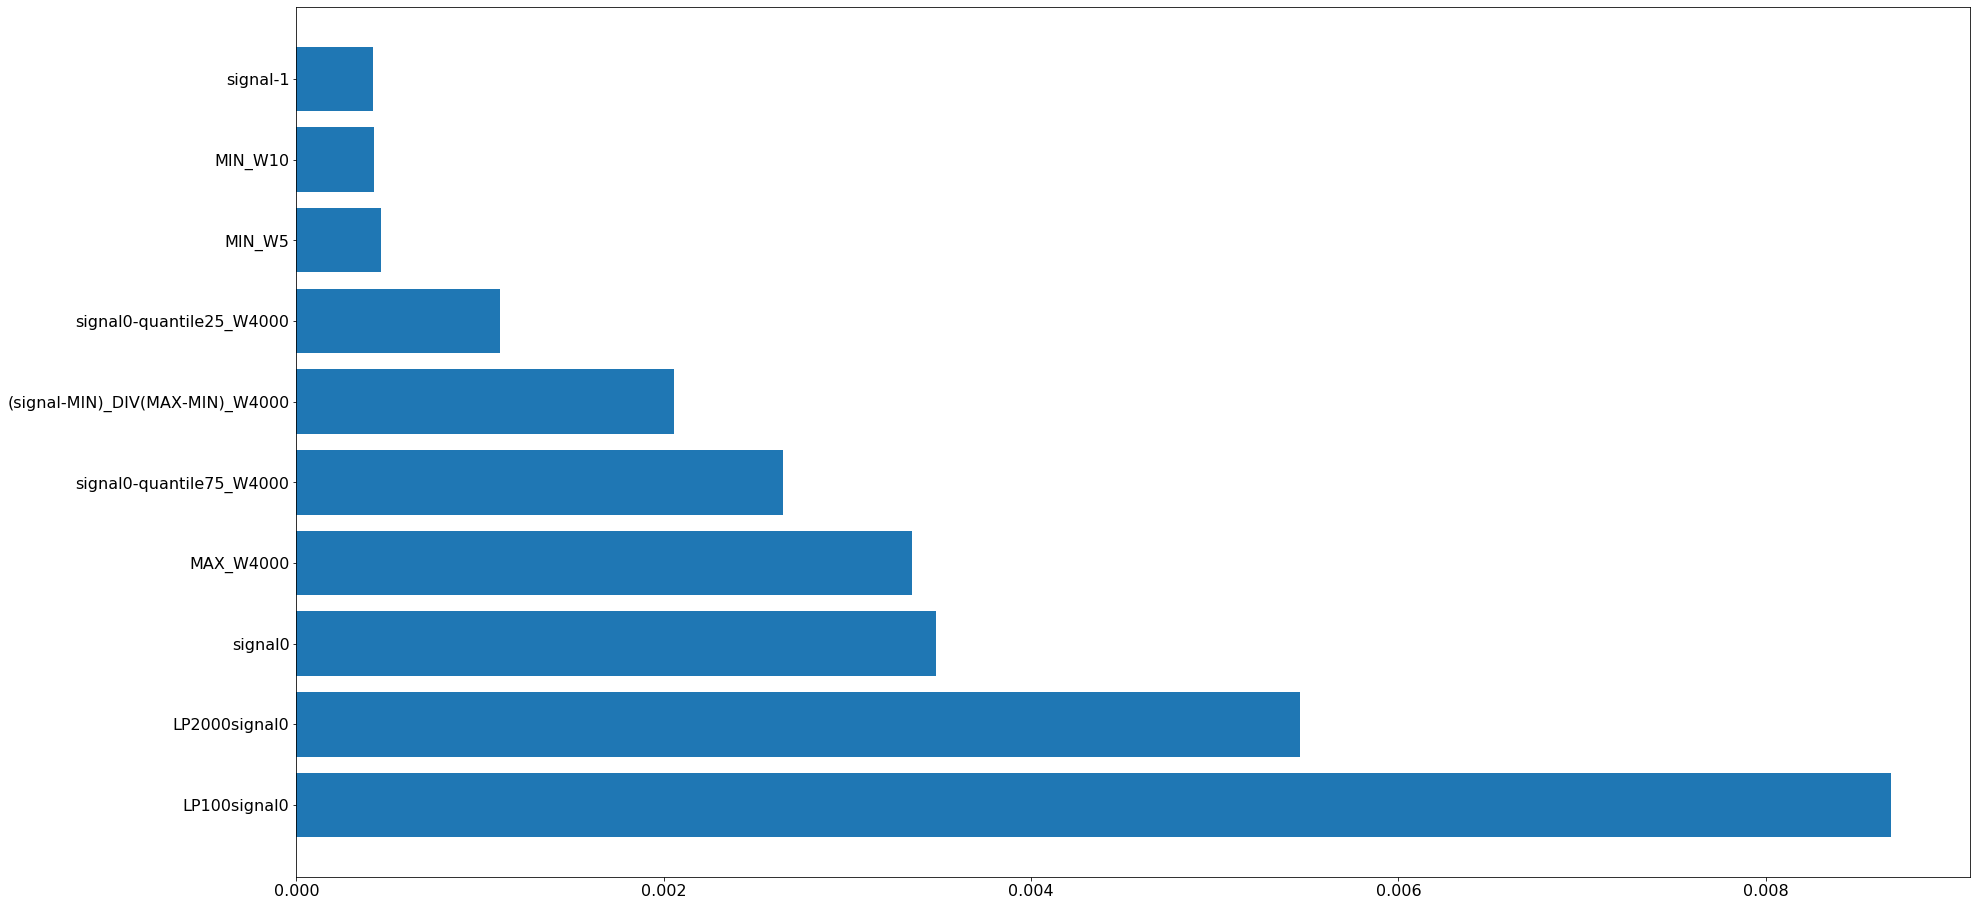

In [17]:
FI=model.get_feature_importance(data=eval_dataset,
                       type='LossFunctionChange' ,
                       prettified=True,
                       thread_count=-1,
                       verbose=False)
plt.figure(figsize=(30,16))
plt.barh(FI['Feature Id'][0:10],FI['Importances'][0:10], align='center')
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.show()

# F1 of the model

In [9]:
def test_data_modelCATBOOST(x,y,model):
    ## INPUTS
    #  df: pandas DataFrame with all features
    #  y: pandas DataFrame with labels
    #  model
    ## OUTPUT
    #  accuracy
    #  F1
    #  y_pred
    y_pred=(model.predict(x,prediction_type='Probability')).argmax(axis=1).reshape(-1,1)
    y_real=y.to_numpy().reshape(-1,1)
    accuracy=(np.double(y_pred==y_real)).sum()/(y_pred.shape[0])
    print("accuracy: %.4f" %accuracy)
    F1 = f1_score(y_real, y_pred, average="macro")
    print("F1 train: %.4f" %F1)
    return accuracy, F1, y_pred

#accuracy_train, F1_train, y_pred_train = test_data_modellgb(x_train.reshape(-1,NCHANNELX),y_train.argmax(axis=2).reshape(-1),bst)
accuracy_CV, F1_CV, y_pred_CV = test_data_modelCATBOOST(x_CV,y_CV,model)

accuracy: 0.9679
F1 train: 0.9374


## TEST DATA

Text(0.5, 0, 'time [$10^{-4} s$]')

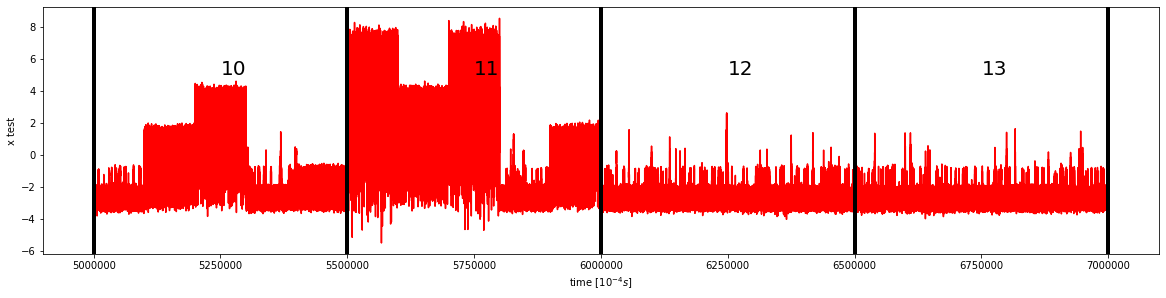

In [10]:
df = pd.read_csv(PATH_DATA+"test_clean.csv")  # Pre-cleaned data
#df = pd.read_csv(PATH_DATA+"test.csv")
x_test=np.array(df.iloc[:,1]).reshape(-1)
time=np.array(df.iloc[:,0])*1e4
del df

BATCHTEST=4

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(time,x_test,color='red')
for i in range(10,14):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*14,linewidth=4, color='black')
plt.ylabel('x test')
plt.xlabel('time [$10^{-4} s$]')

### SUBMISSION FILE

In [14]:
def test_data_CATBOOST(x,model,NITER,batch,nshift,ndshift,window,harmonicHP,harmonicLP,plot=1):
    ## INPUTS
    #  x: numpy data 1 dimension (:,)
    #  model: lgb model
    #  NITER: number of iterations with random noise
    #  batch..plot: input to FEATURE_ENGINEERING
    ## OUTPUT
    #  ya: (:,11) prediction
    cont=0
    print(cont,'/',NITER*2+2)
    xf=pd.DataFrame()
    xf['signal0']=x
    xf=FEATURE_ENGINEERING(xf,batch,nshift,ndshift,window,harmonicHP,harmonicLP,plot=plot)
    ya=model.predict(xf,prediction_type='Probability')
    cont=cont+1
    print(cont,'/',NITER*2+2)
    del xf
    xf=pd.DataFrame()
    xf['signal0']=x[::-1]
    xf=FEATURE_ENGINEERING(xf,batch,nshift,ndshift,window,harmonicHP,harmonicLP,plot=plot)
    ya2=model.predict(xf,prediction_type='Probability')
    ya=ya+ya2[::-1,:]
    cont=cont+1
    print(cont,'/',NITER*2+2)
    del xf
    for j in range(NITER):
        x_aux=x+np.random.rand(x.shape[0])*0.05
        xf=pd.DataFrame()
        xf['signal0']=x_aux
        xf=FEATURE_ENGINEERING(xf,batch,nshift,ndshift,window,harmonicHP,harmonicLP,plot=plot)
        ya=ya+model.predict(xf,prediction_type='Probability')
        cont=cont+1
        print(cont,'/',NITER*2+2)
        del xf
        xf=pd.DataFrame()
        xf['signal0']=x_aux[::-1]
        xf=FEATURE_ENGINEERING(xf,batch,nshift,ndshift,window,harmonicHP,harmonicLP,plot=plot)
        ya2=model.predict(xf,prediction_type='Probability')
        ya=ya+ya2[::-1,:]
        cont=cont+1
        print(cont,'/',NITER*2+2)
        del xf
    ya=ya/cont
    return ya

In [15]:
PATH_MODEL="Trained models/"
model = CatBoostClassifier()
model.load_model(PATH_MODEL+"modelCATBOOST_V20200502")
y_pred = test_data_CATBOOST(x_test,model,20,BATCHTEST,NSHIFT,NDSHIFT,WINDOWS,HARMONICHP,HARMONICLP,plot=0)

np.savetxt('CATBOOST_RESULTS.csv',y_pred)

y_pred=y_pred.argmax(axis=1).reshape(-1,1)

## Submission file
REC=np.hstack([time.reshape(-1,1)/1e4,y_pred])
# Save Numpy array to csv
np.savetxt('submission.csv', REC, delimiter=',', fmt='%.4f,%d',header ='time,open_channels',comments='')

print("submission file created")

0 / 42
1 / 42
2 / 42
3 / 42
4 / 42
5 / 42
6 / 42
7 / 42
8 / 42
9 / 42
10 / 42
11 / 42
12 / 42
13 / 42
14 / 42
15 / 42
16 / 42
17 / 42
18 / 42
19 / 42
20 / 42
21 / 42
22 / 42
23 / 42
24 / 42
25 / 42
26 / 42
27 / 42
28 / 42
29 / 42
30 / 42
31 / 42
32 / 42
33 / 42
34 / 42
35 / 42
36 / 42
37 / 42
38 / 42
39 / 42
40 / 42
41 / 42
42 / 42
submission file created
